In [1]:
!pip install yfinance

In [2]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=f5f63474c1889323651b79cd1d51af84f447e55851a7ada7a7b8a02d85cf5015
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import ta

In [6]:
# 데이터 불러오기 (2013년부터 2023년까지 훈련 데이터, 2024년 1월부터 4월까지 테스트 데이터)
train_data = yf.download('AAPL', start='2013-01-01', end='2024-01-01')
train_data.columns = ['Close','High','Low','Open','Volume']
test_data = yf.download('AAPL', start='2024-01-01', end='2024-05-01')
test_data.columns = ['Close','High','Low','Open','Volume']

# 데이터 전처리 및 피처 엔지니어링
for data in [train_data, test_data]:
    data['SMA_10'] = data['Close'].rolling(window=10).mean()
    data['RSI'] = ta.momentum.RSIIndicator(data['Close']).rsi()
    data.dropna(inplace=True)

# 피처와 타깃 변수 설정
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'RSI']

X_train = train_data[features].values
y_train = (train_data['Close'].shift(-1) > train_data['Close']).astype(int).values[:-1]
X_train = X_train[:-1]

X_test = test_data[features].values
y_test = (test_data['Close'].shift(-1) > test_data['Close']).astype(int).values[:-1]
X_test = X_test[:-1]

# 데이터 정규화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/tmp/ipython-input-6-900995301.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  train_data = yf.download('AAPL', start='2013-01-01', end='2024-01-01')
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-6-900995301.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  test_data = yf.download('AAPL', start='2024-01-01', end='2024-05-01')
[*********************100%***********************]  1 of 1 completed


In [7]:
# 트랜스포머 모델 정의
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # 멀티헤드 어텐션
    x = tf.keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # 피드포워드 네트워크
    x = tf.keras.layers.Dense(ff_dim, activation="relu")(res)
    x = tf.keras.layers.Dense(inputs.shape[-1])(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

트랜스포머 모델 정의  
트랜스포머 모델은 자연어 처리 분야에서 처음 도입되었으나, 시계열 데이터 분석에도 매우 효과적이다. 트랜스포머 모델의 핵심 구성 요소는 멀티헤드 어텐션이다.  

어텐션 메커니즘  
먼저 어텐션 메커니즘에 대해 이해하는 것이 중요하다. 어텐션 메커니즘은 입력 데이터의 중요한 부분에 가중치를 부여하여 모델이 학습할 때 더 중요한 정보에 집중할 수 있도록 돕는다. 어텐션 메커니즘은 주로 다음과 같은 단계로 이루어진다:

1. 쿼리(Query), 키(Key), 값(Value): 입력 데이터는 쿼리, 키, 값 세 가지로 변환된다.
2. 어텐션 스코어(Attention Score): 쿼리와 키의 내적을 계산하여 어텐션 스코어를 구한다.
3. 어텐션 가중치(Attention Weight): 어텐션 스코어를 소프트맥스 함수에 입력하여 가중치를 구한다.
4. 어텐션 출력(Attention Output): 어텐션 가중치와 값의 가중 합을 구하여 최종 출력을 계산한다.
어텐션 메커니즘의 주요 아이디어는 중요한 부분에 더 집중하고, 덜 중요한 부분은 덜 집중하는 것이다.

멀티헤드 어텐션
멀티헤드 어텐션(Multi-Head Attention)은 여러 개의 어텐션 메커니즘을 병렬로 사용하여 다양한 표현을 학습할 수 있도록 한다. 각 어텐션 헤드는 서로 다른 부분에 주의를 기울이며, 이를 통해 모델이 더 풍부한 표현을 학습할 수 있다.

멀티헤드 어텐션의 주요 구성 요소는 다음과 같다:  

1. 헤드(Head): 각 헤드는 독립적인 어텐션 메커니즘을 가지고 있다.
2. 병렬 계산(Parallel Computation): 여러 헤드를 병렬로 계산하여 다양한 패턴을 동시에 학습한다.
3. 결합(Concatenation): 각 헤드의 출력을 결합하여 최종 출력을 만든다. 멀티헤드 어텐션은 다양한 패턴을 동시에 학습할 수 있게 하여, 모델의 성능을 크게 향상시킨다.
아래 코드에서, 멀티헤드 어텐션은 tf.keras.layers.MultiHeadAttention 레이어를 통해 구현된다. 이 레이어는 입력 데이터의 여러 부분에 주의를 기울여 다양한 패턴을 학습할 수 있도록 한다.

트랜스포머 인코더 정의
트랜스포머 인코더는 멀티헤드 어텐션과 피드포워드 네트워크로 구성된다. 인코더는 입력 데이터를 여러 번 처리하여 최종 출력을 생성한다. 각 레이어는 다음과 같이 구성된다:

1. 멀티헤드 어텐션: 입력 데이터의 여러 부분에 동시에 주의를 기울여 중요한 패턴을 학습한다.
2. LayerNormalization: 각 레이어의 출력을 정규화하여 학습을 안정화하고 속도를 높인다.
3. 피드포워드 네트워크: 각 타임스텝의 출력을 더 복잡한 특징으로 변환한다.

In [9]:
def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = tf.keras.layers.Flatten()(x)
    for dim in mlp_units:
        x = tf.keras.layers.Dense(dim, activation="relu")(x)
        x = tf.keras.layers.Dropout(mlp_dropout)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    return tf.keras.Model(inputs, outputs)

모델 빌드 함수 정의    
이제 트랜스포머 인코더를 여러 층 쌓아 트랜스포머 모델을 구성한다. 또한, Flatten 레이어와 MLP(Multi-Layer Perceptron) 레이어를 추가하여 최종 출력을 생성한다. MLP 레이어에 드롭아웃을 적용하여 과적합을 방지한다.

응용 방법
트랜스포머 모델을 사용하여 시계열 데이터를 분석할 때, 다음과 같은 방법으로 모델의 성능을 최적화하고 분석 결과를 향상시킬 수 있다.

첫째, 다양한 하이퍼파라미터를 조정하는 것이 중요하다. 예를 들어, 멀티헤드 어텐션의 헤드 수를 조정함으로써 모델이 데이터를 바라보는 관점을 다양화할 수 있다. 헤드 수를 늘리면 모델이 더 다양한 패턴을 학습할 수 있지만, 계산 비용이 증가한다는 점을 염두에 두어야 한다. 또한, 피드포워드 네트워크의 차원을 조정하여 모델의 복잡성을 조절할 수 있다. 피드포워드 네트워크의 차원을 늘리면 모델이 더 복잡한 패턴을 학습할 수 있지만, 과적합의 위험도 증가한다. 마지막으로, 드롭아웃 비율을 조정하여 모델의 일반화 능력을 향상시킬 수 있다. 드롭아웃 비율을 적절히 조정하면 과적합을 방지하고 모델의 성능을 안정화할 수 있다.

둘째, 데이터 전처리를 통해 모델의 성능을 향상시킬 수 있다. 입력 데이터를 정규화하여 데이터의 스케일을 맞추면 모델이 더 빠르고 안정적으로 학습할 수 있다. 또한, 결측값을 처리하여 데이터의 완전성을 확보하는 것도 중요하다. 결측값이 있는 데이터를 그대로 사용할 경우, 모델의 성능이 저하될 수 있다. 이를 방지하기 위해 결측값을 적절히 처리하는 방법을 고려해야 한다.

셋째, 모델 튜닝을 통해 최적의 하이퍼파라미터를 찾는 과정이 필요하다. 교차 검증을 사용하면 데이터의 특정 부분에만 의존하지 않고 모델의 성능을 평가할 수 있다. 이를 통해 모델이 일반화된 성능을 가지도록 도울 수 있다. 또한, 그리드 서치를 통해 다양한 하이퍼파라미터 조합을 테스트하여 최적의 조합을 찾을 수 있다. 이 과정을 통해 모델의 성능을 최대화할 수 있다.

트랜스포머 모델은 복잡한 시계열 패턴을 효과적으로 학습할 수 있어, 다양한 금융 데이터 분석에 유용하게 사용될 수 있다. 이러한 응용 방법을 통해 트랜스포머 모델을 최적화하고, 이를 바탕으로 다양한 투자 전략을 개발할 수 있다.

In [10]:
# 모델 생성
input_shape = (X_train.shape[1], 1)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25
)

model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 7, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 7, 1)      │      7,169 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 7, 1)      │          2 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 7, 1)      │          0 │ layer_normalizat… │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 7, 4)      │          8 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 7, 1)      │          5 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 7, 1)      │          2 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 7, 1)      │          0 │ layer_normalizat… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 7, 1)      │      7,169 │ add_1[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 7, 1)      │          2 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 7, 1)      │          0 │ layer_normalizat… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 7, 4)      │          8 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 7, 1)      │          5 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 7, 1)      │          2 │ dense_3[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 7, 1)      │          0 │ layer_normalizat… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 7, 1)      │      7,169 │ add_3[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 7, 1)      │          2 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 7, 1)      │          0 │ layer_normalizat… │
│                     │                   │            │ add_3[0][0]     

 Total params: 29,897 (116.79 KB)

 Trainable params: 29,897 (116.79 KB)

 Non-trainable params: 0 (0.00 B)

모델 컴파일 및 학습   
트랜스포머 모델을 구축하고, 컴파일한다. 손실 함수로는 binary_crossentropy를 사용하고, 최적화 도구로 Adam 옵티마이저를 사용한다. 200 에포크 동안 모델을 학습시키고, 학습 곡선을 그려서 모델의 학습 상태를 모니터링한다.

Epoch 1/70
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.5131 - loss: 0.6971 - val_accuracy: 0.5172 - val_loss: 0.6913
Epoch 2/70
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.5146 - loss: 0.6989 - val_accuracy: 0.5281 - val_loss: 0.6912
Epoch 3/70
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.5206 - loss: 0.6950 - val_accuracy: 0.5336 - val_loss: 0.6911
Epoch 4/70
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.5287 - loss: 0.6920 - val_accuracy: 0.5245 - val_loss: 0.6911
Epoch 5/70
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.5150 - loss: 0.6970 - val_accuracy: 0.5281 - val_loss: 0.6911
Epoch 6/70
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.4958 - loss: 0.6992 - val_accuracy: 0.5154 - val_loss: 0.6911
Epoch 7/70
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.5257 - loss: 0.6923 - val_accuracy: 0.5227 - val_loss: 0.6911
Epoch 8/70
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.5139 - loss: 0.7020 - val_accuracy: 0.5263 - v

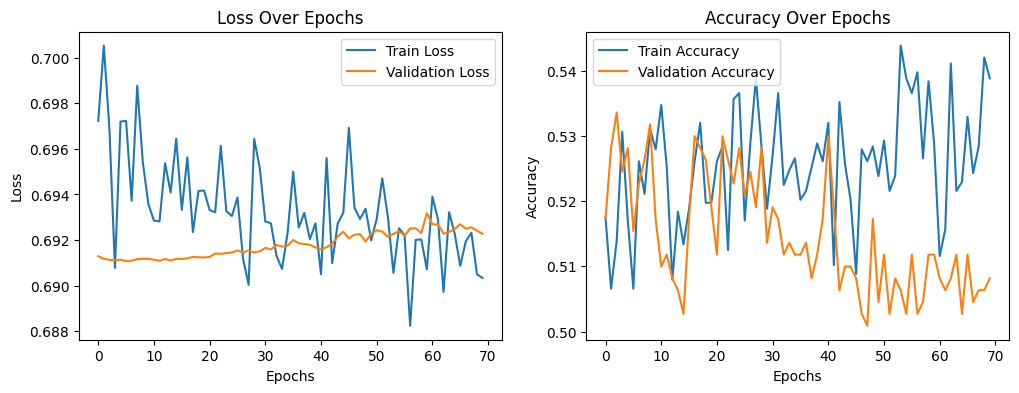

In [12]:
# 모델 학습 (에포크 수 증가)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=70, batch_size=32)

# 학습 곡선 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

학습 곡선 시각화   
학습 곡선을 통해 과적합 여부를 확인할 수 있다. 이 예제에서는 검증 손실이 거의 일정하므로 과적합이 의심된다. 정규화 기법을 추가하거나 모델의 복잡도를 조정하여 이를 개선할 수 있다.

In [13]:
# 훈련 데이터 결과
y_train_pred = model.predict(X_train)
threshold = y_train.mean()  # 훈련 데이터 비율로 트레시홀드 설정
y_train_pred_threshold = (y_train_pred > threshold).astype(int)
accuracy_train = accuracy_score(y_train, y_train_pred_threshold)
conf_matrix_train = confusion_matrix(y_train, y_train_pred_threshold)
print(f"훈련 데이터 정확도: {accuracy_train:.2f}")
print("훈련 데이터 혼동 행렬:")
print(conf_matrix_train)
print("\n훈련 데이터 분류 리포트:")
print(classification_report(y_train, y_train_pred_threshold))

87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
훈련 데이터 정확도: 0.53
훈련 데이터 혼동 행렬:
[[696 605]
 [694 759]]

훈련 데이터 분류 리포트:
              precision    recall  f1-score   support

           0       0.50      0.53      0.52      1301
           1       0.56      0.52      0.54      1453

    accuracy                           0.53      2754
   macro avg       0.53      0.53      0.53      2754
weighted avg       0.53      0.53      0.53      2754



In [14]:
# 테스트 데이터 결과
y_pred = model.predict(X_test)
y_pred_threshold = (y_pred > threshold).astype(int)
accuracy_test = accuracy_score(y_test, y_pred_threshold)
conf_matrix_test = confusion_matrix(y_test, y_pred_threshold)
print(f"테스트 데이터 정확도: {accuracy_test:.2f}")
print("테스트 데이터 혼동 행렬:")
print(conf_matrix_test)
print("\n테스트 데이터 분류 리포트:")
print(classification_report(y_test, y_pred_threshold))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
테스트 데이터 정확도: 0.55
테스트 데이터 혼동 행렬:
[[19 22]
 [ 9 19]]

테스트 데이터 분류 리포트:
              precision    recall  f1-score   support

           0       0.68      0.46      0.55        41
           1       0.46      0.68      0.55        28

    accuracy                           0.55        69
   macro avg       0.57      0.57      0.55        69
weighted avg       0.59      0.55      0.55        69



In [15]:
# 훈련 데이터와 테스트 데이터의 클래스 분포 확인
print("훈련 데이터 클래스 분포:")
print(pd.Series(y_train).value_counts())
print("\n테스트 데이터 클래스 분포:")
print(pd.Series(y_test).value_counts())

훈련 데이터 클래스 분포:
1    1453
0    1301
Name: count, dtype: int64

테스트 데이터 클래스 분포:
0    41
1    28
Name: count, dtype: int64


모델 평가  
훈련 데이터와 테스트 데이터에서의 성능을 평가한 결과, 훈련 데이터의 정확도는 53% 정도, 테스트 데이터의 정확도는 68% 정도이다. (위에서 확인한 분포로 보아서는) 이는 테스트 데이터가 상승장에 편향되어 있기 때문일 수 있다. 따라서 실제로 '정확도'가 아닌 수익률을 봐야 한다. 또한 벤치마크 지표가 필요하다. 예를 들어 buy and hold 전략이 벤치마크가 될 수 있고, S&P 500 지수 추종이 벤치마크가 될 수 있다.

트랜스포머 모델을 사용한 주가 방향성 예측 실습을 통해, 시계열 데이터에서의 패턴 인식과 예측의 가능성을 확인할 수 있었다. 그러나 실전에서는 다양한 정규화 기법과 모델 튜닝이 필요하며, 최종적인 목표는 정확도가 아닌 투자 수익률임을 항상 염두에 두어야 한다.

